### Fit all fovs

In [1]:
from ioMicro import *
import numpy as np
import os
import dask.array as da
def get_tzxy_plus_minus(obj_Xh_plus,obj_Xh_minus,obj_ref_Xh_plus,obj_ref_Xh_minus,resc=5,th=0):
    tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus = np.array([0,0,0]),np.array([0,0,0]),np.array([0,0,0]),0,0
    if (len(obj_Xh_plus)>0) and (len(obj_ref_Xh_plus)>0):
        X = obj_Xh_plus[obj_Xh_plus[:,-1]>th][:,:3]
        X_ref = obj_ref_Xh_plus[obj_ref_Xh_plus[:,-1]>th][:,:3]#obj_ref_Xh_plus[:,:3]
        tzxy_plus,N_plus = get_best_translation_points(X,X_ref,resc=resc,return_counts=True)
    if (len(obj_Xh_minus)>0) and (len(obj_ref_Xh_minus)>0):
        X = obj_Xh_minus[obj_Xh_minus[:,-1]>th][:,:3]
        X_ref = obj_ref_Xh_minus[obj_ref_Xh_minus[:,-1]>th][:,:3]#obj_ref_Xh_plus[:,:3]
        tzxy_minus,N_minus = get_best_translation_points(X,X_ref,resc=resc,return_counts=True)
    if np.max(np.abs(tzxy_minus-tzxy_plus))<=2:
        tzxyf = -(tzxy_plus*N_plus+tzxy_minus*N_minus)/(N_plus+N_minus)
    else:
        tzxyf = -[tzxy_plus,tzxy_minus][np.argmax([N_plus,N_minus])]
    return [tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus]    
def get_best_translation_pointsT(fov,htag,htagref,save_folder,save_folder_ref,set_='',resc=5,th=0):
    fl_feats = rf'{save_folder}\{fov}--{htag}--dapiFeatures.npz'
    fl_feats_ref = rf'{save_folder_ref}\{fov}--{htagref}--dapiFeatures.npz'
    obj_Xh_plus,obj_Xh_minus = np.load(fl_feats)['Xh_plus'],np.load(fl_feats)['Xh_minus']
    obj_ref_Xh_plus,obj_ref_Xh_minus = np.load(fl_feats_ref)['Xh_plus'],np.load(fl_feats_ref)['Xh_minus']
    tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus = get_tzxy_plus_minus(obj_Xh_plus,obj_Xh_minus,obj_ref_Xh_plus,obj_ref_Xh_minus,resc=resc,th=th)
    return tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus
def read_im(fl,return_pos=False,ncols=4):
    data = os.path.dirname(fl)+os.sep+os.path.basename(fl).split('_')[-1].split('.')[0]+r'\data'
    im = da.from_zarr(fl,component=data)
    im = im[1:]
    im = im.reshape([-1,ncols,im.shape[-2],im.shape[-1]])
    im = im.swapaxes(0,1)
    
    im=im.astype(np.float32)
    im=im*im
    if return_pos is False:
        return im
    else:
        fl_xml = fl.replace('.zarr','.xml')
        x,y = [eval(ln.split('>')[1].split('<')[0]) for ln in open(fl_xml) if 'stage_position' in ln][0]
        return im,x,y
def get_icodesV3(dec,nmin_bits=3,iH=-3,save=False,make_unique=False):
    import time
    start = time.time()
    lens = dec.lens
    res_unfolder = dec.res_unfolder
    Mlen = np.max(lens)
    print("Calculating indexes within cluster...")
    res_is = np.tile(np.arange(Mlen), len(lens))
    res_is = res_is[res_is < np.repeat(lens, Mlen)]
    print("Calculating index of molecule...")
    ires = np.repeat(np.arange(len(lens)), lens)
    #r0 = np.array([r[0] for r in res for r_ in r])
    print("Calculating index of first molecule...")
    r0i = np.concatenate([[0],np.cumsum(lens)])[:-1]
    r0 = res_unfolder[np.repeat(r0i, lens)]
    print("Total time unfolded molecules:",time.time()-start)
    
    ### torch
    ires = torch.from_numpy(ires.astype(np.int64))
    res_unfolder = torch.from_numpy(res_unfolder.astype(np.int64))
    res_is = torch.from_numpy(res_is.astype(np.int64))
    
    import time
    start = time.time()
    print("Computing score...")
    scoreF = torch.from_numpy(dec.XH[:,iH])[res_unfolder]
    print("Total time computing score:",time.time()-start)
    
    
    ### organize molecules in blocks for each cluster
    def get_asort_scores():
        val = torch.max(scoreF)+2
        scoreClu = torch.zeros([len(lens),Mlen],dtype=torch.float64)+val
        scoreClu[ires,res_is]=scoreF
        asort = scoreClu.argsort(-1)
        scoreClu = torch.gather(scoreClu,dim=-1,index=asort)
        scoresF2 = scoreClu[scoreClu<val-1]
        return asort,scoresF2
    def get_reorder(x,val=-1):
        if type(x) is not torch.Tensor:
            x = torch.from_numpy(np.array(x))
        xClu = torch.zeros([len(lens),Mlen],dtype=x.dtype)+val
        xClu[ires,res_is] = x
        xClu = torch.gather(xClu,dim=-1,index=asort)
        xf = xClu[xClu>val]
        return xf
    
    
    import time
    start = time.time()
    print("Computing sorting...")
    asort,scoresF2 = get_asort_scores()
    res_unfolder2 = get_reorder(res_unfolder,val=-1)
    del asort
    del scoreF
    print("Total time sorting molecules by score:",time.time()-start)
    
    
    
    import time
    start = time.time()
    print("Finding best bits per molecules...")
    
    Rs = dec.XH[:,-1].astype(np.int64)
    Rs = torch.from_numpy(Rs)
    Rs_U = Rs[res_unfolder2]
    nregs,nbits = dec.codes_01.shape
    score_bits = torch.zeros([len(lens),nbits],dtype=scoresF2.dtype)-1
    score_bits[ires,Rs_U]=scoresF2
    
    
    codes_lib = torch.from_numpy(np.array(dec.codes__))
    
    
    codes_lib_01 = torch.zeros([len(codes_lib),nbits],dtype=score_bits.dtype)
    for icd,cd in enumerate(codes_lib):
        codes_lib_01[icd,cd]=1
    codes_lib_01 = codes_lib_01/torch.norm(codes_lib_01,dim=-1)[:,np.newaxis]
    print("Finding best code...")
    batch = 10000
    icodes_best = torch.zeros(len(score_bits),dtype=torch.int64)
    dists_best = torch.zeros(len(score_bits),dtype=torch.float32)
    from tqdm import tqdm
    for i in tqdm(range((len(score_bits)//batch)+1)):
        score_bits_ = score_bits[i*batch:(i+1)*batch]
        if len(score_bits_)>0:
            score_bits__ = score_bits_.clone()
            score_bits__[score_bits__==-1]=0
            score_bits__ = score_bits__/torch.norm(score_bits__,dim=-1)[:,np.newaxis]
            Mul = torch.matmul(score_bits__,codes_lib_01.T)
            max_ = torch.max(Mul,dim=-1)
            icodes_best[i*batch:(i+1)*batch] = max_.indices
            dists_best[i*batch:(i+1)*batch] = 2-2*max_.values
    
    
    keep_all_bits = torch.sum(score_bits.gather(1,codes_lib[icodes_best])>=0,-1)>=nmin_bits
    dists_best_ = dists_best[keep_all_bits]
    score_bits = score_bits[keep_all_bits]
    icodes_best_ = icodes_best[keep_all_bits]
    icodesN=icodes_best_
    
    indexMols_ = torch.zeros([len(lens),nbits],dtype=res_unfolder2.dtype)-1
    indexMols_[ires,Rs_U]=res_unfolder2
    indexMols_ = indexMols_[keep_all_bits]
    indexMols_ = indexMols_.gather(1,codes_lib[icodes_best_])
    
    # make unique
    dec.dist_best = dists_best_.numpy()
    if make_unique:
        indexMols_,rinvMols = get_unique_ordered(indexMols_)
        icodesN = icodesN[rinvMols]
        dec.dist_best = dists_best_[rinvMols].numpy()
    XH = torch.from_numpy(dec.XH)
    XH_pruned = XH[indexMols_]
    XH_pruned[indexMols_==-1]=np.nan
    
    
    dec.XH_pruned=XH_pruned.numpy()
    dec.icodesN=icodesN.numpy()
    if save:
        np.savez_compressed(dec.decoded_fl,XH_pruned=dec.XH_pruned,icodesN=dec.icodesN,gns_names = np.array(dec.gns_names),dist_best=dec.dist_best)
    print("Total time best bits per molecule:",time.time()-start)
def get_XH(self,fov,set_,ncols=3,nbits=16,th_h=0,tag_keep='MER',medH_fl=None,color_fl=None):
    self.set_ = set_
    save_folder = self.save_folder
    drift_fl = save_folder+os.sep+'driftNew_'+fov.split('.')[0]+'--'+set_+'.pkl'
    if os.path.exists(drift_fl):
        drifts,all_flds,fov,fl_ref = pickle.load(open(drift_fl,'rb'))
        self.drifts,self.all_flds,self.fov,self.fl_ref = drifts,all_flds,fov,fl_ref
    else:
        drift_fl = save_folder+os.sep+'driftNew_'+fov.split('.')[0]+'--'+set_+'.pkl'
        drifts,all_flds,fov = pickle.load(open(drift_fl,'rb'))
        self.drifts,self.all_flds,self.fov = drifts,all_flds,fov

    XH = []
    for iH in tqdm(np.arange(len(all_flds))):
        fld = all_flds[iH]
        if tag_keep in os.path.basename(fld):
            for icol in range(ncols):
                tag = os.path.basename(fld)
                save_fl = save_folder+os.sep+fov.split('.')[0]+'--'+tag+'--col'+str(icol)+'__Xhfits.npy.npz'
                if not os.path.exists(save_fl):save_fl = save_fl.replace('.npy','')
                Xh = np.load(save_fl,allow_pickle=True)['Xh']
                tzxy = drifts[iH][0]
                        
                ih = get_iH(fld) # get bit
                is_low = 'low' in tag
                bit = (ih-1)*ncols+icol
                print(Xh.shape)
                if len(Xh.shape):
                    if medH_fl is not None:
                        medHs = np.load(medH_fl)['medHs']
                        Xh[:,-1]=Xh[:,-1]/medHs[bit]
                if len(Xh.shape):
                    if len(Xh):
                        Xh = Xh[Xh[:,-1]>th_h]
                    if len(Xh):
                        
                        icolR = np.array([[icol,bit]]*len(Xh))

                        if color_fl is not None:
                            ms = np.load(color_fl,allow_pickle=True)
                            Xh[:,[0,1,2]] = apply_colorcor(Xh[:,[0,1,2]],ms[icol])
                        Xh[:,:3]+=tzxy# drift correction
                        XH_ = np.concatenate([Xh,icolR],axis=-1)
                        XH.extend(XH_)
    self.XH = np.array(XH)

In [2]:
def finished_fitting(save_folder,fov,htags):
    is_good = []
    for htag in htags:
        fl_feats = rf'{save_folder}\{fov}--{htag}--dapiFeatures.npz'
        is_good.append(os.path.exists(fl_feats))
    return np.all(is_good)

import time


In [3]:
fls = glob.glob(r'S:\12_04_2025_JenieSample\H1_MER_set1\*.zarr')
fovs = [os.path.basename(fl).replace('.zarr','')for fl in fls]

In [5]:
assert True

In [ ]:
#fov = 'Conv_zscan1__434'
fov = 'Conv_zscan1__434'
for fov in tqdm(fovs):
    try:
        verbose = False
        save_folder =save_folder_ref= r'S:\12_04_2025_JenieSample\mermake_fits'
        
        dec = decoder_simple(save_folder,fov=fov,set_='')
        if not os.path.exists(dec.decoded_fl):
            ### compute drift
            
            htags = [rf'H{i+1}_MER_set1' for i in np.arange(9)]
            assert finished_fitting(save_folder,fov,htags)
                #time.sleep(10)
            htagref = htags[0]
            ### compute drift for all MERFISH rounds
            drift_fl = save_folder+os.sep+'driftNew_'+fov+'--.pkl'
            if not os.path.exists(drift_fl):
                newdrifts = []
                for htag in htags:
                    drft = get_best_translation_pointsT(fov,htag,htagref,save_folder,save_folder_ref,set_='',resc=5,th=0)
                    if verbose:
                        print(htag,drft)
                    newdrifts.append(drft)
                pickle.dump([newdrifts,htags,fov,htagref],open(drift_fl,'wb'))
            
            ### load in data
            dec = decoder_simple(save_folder,fov=fov,set_='')
            get_XH(dec,fov,'',ncols=3,nbits=100,th_h=4000,tag_keep='',
                       color_fl='3color_coorection_Mammoth.pkl',
                       medH_fl='medHBRBB.npz')
            
            #dec.XH = dec.XH[dec.XH[:,-4]>0.7]
            dec.ncols = 3
            lib_fl = r'codebook_BRBB_500Markergn_NewAdaptors.csv'
            dec.load_library(lib_fl,nblanks=-1)
            get_intersV2(dec,nmin_bits=3,dinstance_th=2,enforce_color=False,enforce_set=None,redo=False) #default:redo = False
            get_icodesV3(dec,nmin_bits=3,iH=-3)
            get_score(dec)
            
            scores_ref_fl = save_folder+os.sep+'scores_BRBB.npy'
            if not os.path.exists(scores_ref_fl):
                score_ref = np.sort(dec.score,axis=0)
                dec.score_ref = score_ref
                np.save(scores_ref_fl,score_ref)
            else:
                dec.score_ref = np.load(scores_ref_fl)
                
            set_scoreA(dec)
            scoreA = dec.scoreA
            
            keep = dec.scoreA>-3
            np.savez_compressed(dec.decoded_fl,XH_pruned=dec.XH_pruned[keep],
                                icodesN=dec.icodesN[keep],
                                gns_names = np.array(dec.gns_names),
                                dist_best=dec.dist_best[keep],
                               scoreA = dec.scoreA[keep])
            
            if verbose:
                bad_inds = [ign for ign,gn in enumerate(dec.gns_names) if 'blank' in gn]
                is_bad = np.in1d(dec.icodesN,bad_inds)
                is_good_gn = ~is_bad
                th_min=-7.5
                plt.figure()
                kp = scoreA>th_min
                plt.hist(scoreA[(is_good_gn)&kp],density=True,bins=100,alpha=0.5,label='all genes')
                plt.hist(scoreA[(~is_good_gn)&kp],density=True,bins=100,alpha=0.5,label='blanks');
                plt.legend()
            
                dec.th=-1.
                dec.gns_names = np.array(dec.gns_names)
                plot_statistics(dec)
    except:
        print(f"Failed:{fov}")

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

(483618, 8)
(560209, 8)
(651575, 8)



 11%|█████████▎                                                                          | 1/9 [00:01<00:10,  1.26s/it]

(315913, 8)
(610390, 8)


  2%|██                                                                               | 14/563 [00:01<01:18,  7.01it/s]

Failed:Conv_zscan1__013



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

(488446, 8)
(562741, 8)
(642848, 8)



 11%|█████████▎                                                                          | 1/9 [00:01<00:09,  1.15s/it]

(297208, 8)
(635878, 8)
(713483, 8)



 22%|██████████████████▋                                                                 | 2/9 [00:02<00:07,  1.04s/it]

(312330, 8)
(476291, 8)
(585895, 8)



 33%|████████████████████████████                                                        | 3/9 [00:03<00:06,  1.01s/it]

(285573, 8)
(520149, 8)
(660885, 8)



 44%|█████████████████████████████████████▎                                              | 4/9 [00:04<00:04,  1.02it/s]

(264143, 8)
(487745, 8)
(524555, 8)



 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:04<00:03,  1.04it/s]

(264433, 8)
(458369, 8)
(608097, 8)



 67%|████████████████████████████████████████████████████████                            | 6/9 [00:05<00:02,  1.06it/s]

(242427, 8)
(500518, 8)
(674481, 8)



 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:06<00:01,  1.04it/s]

(332697, 8)
(478852, 8)
(585909, 8)



 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:07<00:00,  1.05it/s]

(235920, 8)
(433129, 8)
(681571, 8)



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.03it/s]


Calculating lengths of clusters...
Unfolding indexes...
Saving to file: S:\12_04_2025_JenieSample\mermake_fits\resNew_Conv_zscan1__021--.npz
Calculating indexes within cluster...
Calculating index of molecule...
Calculating index of first molecule...
Total time unfolded molecules: 3.3681256771087646
Computing score...
Total time computing score: 0.08716416358947754
Computing sorting...
Total time sorting molecules by score: 1.5562663078308105
Finding best bits per molecules...
Finding best code...



100%|███████████████████████████████████████████████████████████████████████████████| 803/803 [00:01<00:00, 479.17it/s]


Total time best bits per molecule: 2.721467971801758


  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

(500253, 8)
(572272, 8)
(658652, 8)



 11%|█████████▎                                                                          | 1/9 [00:01<00:10,  1.27s/it]

(307790, 8)
(629412, 8)
(714697, 8)



 22%|██████████████████▋                                                                 | 2/9 [00:02<00:07,  1.11s/it]

(325958, 8)
(488991, 8)
(596100, 8)



 33%|████████████████████████████                                                        | 3/9 [00:03<00:06,  1.05s/it]

(287770, 8)
(515997, 8)
(656865, 8)



 44%|█████████████████████████████████████▎                                              | 4/9 [00:04<00:05,  1.02s/it]

(278455, 8)
(493597, 8)
(539070, 8)



 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:05<00:03,  1.00it/s]

(279872, 8)
(470750, 8)
(610507, 8)



 67%|████████████████████████████████████████████████████████                            | 6/9 [00:06<00:03,  1.01s/it]

(254715, 8)
(512548, 8)
(668326, 8)



 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:07<00:02,  1.00s/it]

(339218, 8)
(479923, 8)
(589448, 8)



 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:08<00:00,  1.01it/s]

(252285, 8)
(442608, 8)
(690504, 8)



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


Calculating lengths of clusters...
Unfolding indexes...
Saving to file: S:\12_04_2025_JenieSample\mermake_fits\resNew_Conv_zscan1__022--.npz
Calculating indexes within cluster...
Calculating index of molecule...
Calculating index of first molecule...
Total time unfolded molecules: 3.420459508895874
Computing score...
Total time computing score: 0.08414793014526367
Computing sorting...
Total time sorting molecules by score: 1.7557287216186523
Finding best bits per molecules...
Finding best code...



100%|███████████████████████████████████████████████████████████████████████████████| 814/814 [00:01<00:00, 453.89it/s]


Total time best bits per molecule: 2.84462308883667


  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

(497712, 8)
(565066, 8)
(656354, 8)



 11%|█████████▎                                                                          | 1/9 [00:01<00:09,  1.21s/it]

(303680, 8)
(629250, 8)
(718351, 8)



 22%|██████████████████▋                                                                 | 2/9 [00:02<00:07,  1.07s/it]

(320968, 8)
(477826, 8)
(593755, 8)



 33%|████████████████████████████                                                        | 3/9 [00:03<00:06,  1.04s/it]

(278234, 8)
(527443, 8)
(682117, 8)



 44%|█████████████████████████████████████▎                                              | 4/9 [00:04<00:05,  1.04s/it]

(271826, 8)
(490587, 8)
(531333, 8)



 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:05<00:04,  1.01s/it]

(274329, 8)
(458954, 8)
(604552, 8)



 67%|████████████████████████████████████████████████████████                            | 6/9 [00:06<00:03,  1.00s/it]

(251489, 8)
(512836, 8)
(670294, 8)



 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:07<00:01,  1.02it/s]

(333529, 8)
(477832, 8)
(590882, 8)



 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:08<00:01,  1.03s/it]

(246873, 8)
(435464, 8)
(689814, 8)



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.02s/it]


Calculating lengths of clusters...
Unfolding indexes...
Saving to file: S:\12_04_2025_JenieSample\mermake_fits\resNew_Conv_zscan1__023--.npz
Calculating indexes within cluster...
Calculating index of molecule...
Calculating index of first molecule...
Total time unfolded molecules: 3.144305944442749
Computing score...
Total time computing score: 0.06874775886535645
Computing sorting...
Total time sorting molecules by score: 1.6192994117736816
Finding best bits per molecules...
Finding best code...



100%|███████████████████████████████████████████████████████████████████████████████| 802/802 [00:01<00:00, 419.24it/s]


Total time best bits per molecule: 2.960618734359741


  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

(495889, 8)
(566526, 8)
(658425, 8)



 11%|█████████▎                                                                          | 1/9 [00:01<00:09,  1.20s/it]

(306969, 8)
(637160, 8)
(715968, 8)



 22%|██████████████████▋                                                                 | 2/9 [00:02<00:07,  1.04s/it]

(317282, 8)
(479265, 8)
(593586, 8)



 33%|████████████████████████████                                                        | 3/9 [00:03<00:06,  1.03s/it]

(280469, 8)
(523639, 8)
(666920, 8)



 44%|█████████████████████████████████████▎                                              | 4/9 [00:04<00:05,  1.02s/it]

(265843, 8)
(485886, 8)
(534393, 8)



 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:05<00:03,  1.01it/s]

(286818, 8)
(464563, 8)
(610767, 8)



 67%|████████████████████████████████████████████████████████                            | 6/9 [00:06<00:03,  1.01s/it]

(253048, 8)
(510090, 8)
(668775, 8)



 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:07<00:02,  1.01s/it]

(335843, 8)
(477793, 8)
(591707, 8)



 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:08<00:00,  1.02it/s]

(239709, 8)
(429556, 8)
(684917, 8)



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.00it/s]


Calculating lengths of clusters...
Unfolding indexes...
Saving to file: S:\12_04_2025_JenieSample\mermake_fits\resNew_Conv_zscan1__024--.npz
Calculating indexes within cluster...
Calculating index of molecule...
Calculating index of first molecule...
Total time unfolded molecules: 3.099339485168457
Computing score...
Total time computing score: 0.08172869682312012
Computing sorting...
Total time sorting molecules by score: 9.604463815689087
Finding best bits per molecules...
Finding best code...



100%|███████████████████████████████████████████████████████████████████████████████| 806/806 [00:01<00:00, 413.72it/s]


Total time best bits per molecule: 3.262592315673828


  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

(510341, 8)
(575614, 8)
(666500, 8)



 11%|█████████▎                                                                          | 1/9 [00:01<00:09,  1.22s/it]

(316609, 8)
(639324, 8)
(723086, 8)



 22%|██████████████████▋                                                                 | 2/9 [00:02<00:07,  1.10s/it]

(329100, 8)
(484054, 8)
(601962, 8)



 33%|████████████████████████████                                                        | 3/9 [00:03<00:06,  1.05s/it]

(286826, 8)
(540320, 8)
(690264, 8)



 44%|█████████████████████████████████████▎                                              | 4/9 [00:04<00:05,  1.05s/it]

(280101, 8)
(496975, 8)
(539578, 8)



 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:05<00:04,  1.03s/it]

(282123, 8)
(468921, 8)
(611982, 8)



 67%|████████████████████████████████████████████████████████                            | 6/9 [00:06<00:03,  1.03s/it]

(258126, 8)
(522922, 8)
(672241, 8)



 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:07<00:02,  1.03s/it]

(348470, 8)
(483780, 8)
(601546, 8)



 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:08<00:01,  1.03s/it]

(256324, 8)
(445246, 8)
(697906, 8)



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


Calculating lengths of clusters...
Unfolding indexes...
Saving to file: S:\12_04_2025_JenieSample\mermake_fits\resNew_Conv_zscan1__025--.npz
Calculating indexes within cluster...
Calculating index of molecule...
Calculating index of first molecule...
Total time unfolded molecules: 3.5581142902374268
Computing score...
Total time computing score: 0.08330106735229492
Computing sorting...
Total time sorting molecules by score: 18.331573009490967
Finding best bits per molecules...
Finding best code...



100%|███████████████████████████████████████████████████████████████████████████████| 818/818 [00:01<00:00, 474.06it/s]


Total time best bits per molecule: 3.8324780464172363


  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

(493540, 8)
(553238, 8)
(656650, 8)



 11%|█████████▎                                                                          | 1/9 [00:01<00:09,  1.19s/it]

(298838, 8)
(620111, 8)
(718387, 8)



 22%|██████████████████▋                                                                 | 2/9 [00:02<00:07,  1.06s/it]

(312682, 8)
(463633, 8)
(596462, 8)



 33%|████████████████████████████                                                        | 3/9 [00:03<00:06,  1.02s/it]

(269628, 8)
(509728, 8)
(683659, 8)



 44%|█████████████████████████████████████▎                                              | 4/9 [00:04<00:05,  1.01s/it]

(256892, 8)
(486357, 8)
(511858, 8)



 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:05<00:03,  1.02it/s]

(270274, 8)
(457438, 8)
(605287, 8)



 67%|████████████████████████████████████████████████████████                            | 6/9 [00:05<00:02,  1.03it/s]

(242052, 8)
(509650, 8)
(659850, 8)



 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:06<00:01,  1.04it/s]

(316781, 8)
(467755, 8)
(589623, 8)



 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:07<00:00,  1.04it/s]

(238872, 8)
(436860, 8)
(687695, 8)



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.02it/s]


Calculating lengths of clusters...
Unfolding indexes...
Saving to file: S:\12_04_2025_JenieSample\mermake_fits\resNew_Conv_zscan1__026--.npz
Calculating indexes within cluster...
Calculating index of molecule...
Calculating index of first molecule...
Total time unfolded molecules: 3.2704999446868896
Computing score...
Total time computing score: 0.09045696258544922
Computing sorting...
Total time sorting molecules by score: 11.85600209236145
Finding best bits per molecules...
Finding best code...



100%|███████████████████████████████████████████████████████████████████████████████| 778/778 [00:01<00:00, 546.65it/s]


Total time best bits per molecule: 4.077697277069092


  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

(470602, 8)
(547588, 8)
(636931, 8)



 11%|█████████▎                                                                          | 1/9 [00:01<00:08,  1.12s/it]

(291916, 8)
(595944, 8)
(697420, 8)



 22%|██████████████████▋                                                                 | 2/9 [00:02<00:07,  1.04s/it]

(312163, 8)
(459038, 8)
(573114, 8)



 33%|████████████████████████████                                                        | 3/9 [00:03<00:05,  1.02it/s]

(253479, 8)
(467368, 8)
(647459, 8)



 44%|█████████████████████████████████████▎                                              | 4/9 [00:03<00:04,  1.04it/s]

(235594, 8)
(460407, 8)
(497376, 8)



 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:04<00:03,  1.08it/s]

(254653, 8)
(437108, 8)
(592778, 8)



 67%|████████████████████████████████████████████████████████                            | 6/9 [00:05<00:02,  1.03it/s]

(232232, 8)
(483259, 8)
(633283, 8)



 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:06<00:01,  1.04it/s]

(298404, 8)
(444026, 8)
(575284, 8)



 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:07<00:00,  1.05it/s]

(213900, 8)
(397271, 8)
(664424, 8)



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.04it/s]


Calculating lengths of clusters...
Unfolding indexes...
Saving to file: S:\12_04_2025_JenieSample\mermake_fits\resNew_Conv_zscan1__027--.npz
Calculating indexes within cluster...
Calculating index of molecule...
Calculating index of first molecule...
Total time unfolded molecules: 2.8290212154388428
Computing score...
Total time computing score: 0.07515120506286621
Computing sorting...
Total time sorting molecules by score: 15.989121198654175
Finding best bits per molecules...
Finding best code...



100%|███████████████████████████████████████████████████████████████████████████████| 733/733 [00:01<00:00, 405.82it/s]


C:\Users\User\AppData\Local\Temp\ipykernel_23204\2741607687.py:2: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  is_bad = np.in1d(dec.icodesN,bad_inds)


[np.str_('Slc17a7'), np.str_('Nfix'), np.str_('Rgs4'), np.str_('Ptk2b'), np.str_('Slc30a3'), np.str_('Pou3f3'), np.str_('Slc1a3'), np.str_('Sv2b'), np.str_('Rasgrp1'), np.str_('Cacng3'), np.str_('Igfbp4'), np.str_('Grm3'), np.str_('Lamp5'), np.str_('Npnt'), np.str_('Ccn3'), np.str_('Gpr88'), np.str_('Zeb2'), np.str_('Epha4'), np.str_('Rgs6'), np.str_('Slit3'), np.str_('Sorcs3'), np.str_('Nr2f1'), np.str_('Lhx2'), np.str_('Zbtb16'), np.str_('Kcnk9'), np.str_('Pdzrn3'), np.str_('Igfbp2'), np.str_('Sulf2'), np.str_('Cd34'), np.str_('Gja1')]


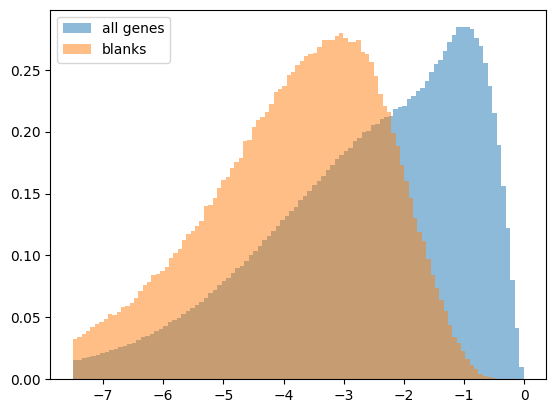

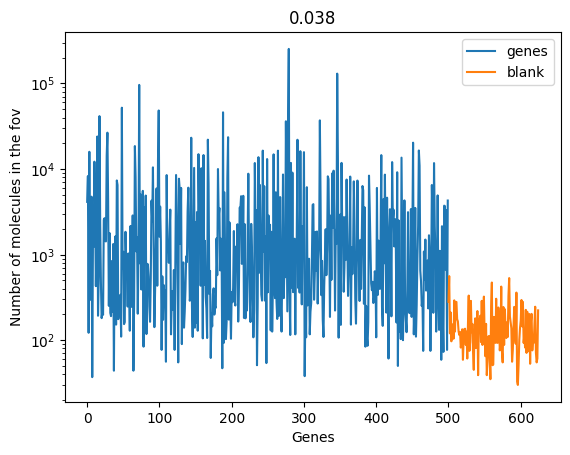

In [8]:
bad_inds = [ign for ign,gn in enumerate(dec.gns_names) if 'blank' in gn]
is_bad = np.in1d(dec.icodesN,bad_inds)
is_good_gn = ~is_bad
th_min=-7.5
plt.figure()
kp = scoreA>th_min
plt.hist(scoreA[(is_good_gn)&kp],density=True,bins=100,alpha=0.5,label='all genes')
plt.hist(scoreA[(~is_good_gn)&kp],density=True,bins=100,alpha=0.5,label='blanks');
plt.legend()

dec.th=-1.5
dec.gns_names = np.array(dec.gns_names)
plot_statistics(dec)

In [9]:
def plot_multigenes(self,genes=['Gad1','Sox9'],colors=['r','g','b','m','c','y','w'],smin=3,smax=10,viewer = None,
                    drift=[0,0,0],resc=[1,1,1]):
    icodesN,XH_pruned = self.icodesN,self.XH_pruned
    scoreA=self.scoreA
    th=self.th
    gns_names = list(self.gns_names)
    
    Xcms = np.nanmean(XH_pruned,axis=1)
    keep = scoreA>th
    X = (Xcms[:,:3][keep]-drift)/resc  
    H = scoreA[keep]
    H -= np.min(H)
    icodesf = icodesN[keep]
    size = smin+np.clip(H/np.max(H),0,1)*(smax-smin)
    
    if viewer is None:
        import napari
        viewer = napari.Viewer()
    for igene,gene in enumerate(genes):
        color= colors[igene%len(colors)]
        icode = gns_names.index(gene)
        is_code = icode==icodesf
        viewer.add_points(X[is_code][:,1:],size=size[is_code],face_color=color,name=gene,border_width=0)
        #viewer.layers[-1].visible=False
    return viewer

In [10]:
plot_multigenes(dec,genes=['Slc17a7',
                           'Pou3f3','Gja1', 'Slc1a3','Gad2','Lamp5','Megf11','Igfbpl1'])

Viewer(camera=Camera(center=(0.0, np.float64(1394.7637012402217), np.float64(1405.3579219182332)), zoom=np.float64(0.20327479095506823), angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=2, ndisplay=2, order=(0, 1), axis_labels=('0', '1'), rollable=(True, True), range=(RangeTuple(start=np.float64(-4.176780462265015), stop=np.float64(2795.8423665364585), step=np.float64(1.0)), RangeTuple(start=np.float64(4.211069981257121), stop=np.float64(2808.3449096679688), step=np.float64(1.0))), margin_left=(0.0, 0.0), margin_right=(0.0, 0.0), point=(np.float64(1393.823219537735), np.float64(1404.2110699812572)), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Points layer 'Slc17a7' at 0x2090770f670>, <Points layer 'Pou3f3' at 0x20906a694f0>, <Points layer 'Gja1' at 0x2090770f4c0>, <Points layer 'Slc1a3' at 0x209254df7f0>, <Po

Cannot find steve
